In [185]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.special import gamma
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [186]:
df = pd.read_csv('dataset/test/manual_data.csv')
# df = pd.read_csv('dataset/test/manual_data_categorical.csv')
df = df.apply(LabelEncoder().fit_transform)
n = len(df)
k = round((n**(3/8))+1)
# df.pop('id')
# result1 = pd.read_csv('dataset/test/result1.csv')
# result2 = pd.read_csv('dataset/test/result2.csv')

# score1 = silhouette_score(df,result1)
# score2 = silhouette_score(df,result2)

In [187]:
scaler = StandardScaler()
scale = scaler.fit_transform(df)

In [188]:
model = NearestNeighbors(n_neighbors=k, metric='euclidean')

# Fit the model to the data
model.fit(scale)

# Find the k nearest neighbors for each point in X
d, i = model.kneighbors(scale)

In [189]:
distances = d[:, 1:]
indices = i[:, 1:]
further_n = [row[-1] for row in d]
further_n = np.array(further_n)

In [190]:
Vx = np.prod(distances, axis=1)
# Vx = np.pi**((k-1)/2) / gamma((k-1)/2 + 1) * further_n**(k-1)

mulByK = distances * (k-1)
# Hx = np.pi**((k-1)/2) / gamma((k-1)/2 + 1) * (further_n*(k-1))**(k-1)
Hx = mulByK.sum(axis=1)

onePernVx = 1 / (n * Vx)

de = 1 - (distances / Hx.reshape(n,1))
sum = Vx * (de.sum(axis=1))

In [191]:
def triangular_kernel(x):
    return np.maximum(0, 1 - np.abs(x))

In [192]:
px = np.array([triangular_kernel(x) for x in sum])

In [203]:
indices.shape[1]

IndexError: tuple index out of range

In [204]:
# Create an array of zeros with the same shape as indices
pxMatrix = np.zeros(indices.shape)

# Loop through the indices array and replace with the corresponding value
for i in range(indices.shape[0]):
    for j in range(indices.shape[1]):
        pxMatrix[i, j] = px[indices[i, j]]

print(pxMatrix)

IndexError: tuple index out of range

In [195]:
mx = indices + 1

In [196]:
max_index_values = []

# Loop through each sub-array in the value array
for i, sub_array in enumerate(pxMatrix):
    # Find the index of the maximal value in the sub-array
    max_index = np.argmax(sub_array)
    # Get the corresponding index from the index array
    max_index_value = mx[i, max_index]
    # Append the max_index_value to the new array
    max_index_values.append([i + 1, max_index_value])

# Print the result
print(max_index_values)

[[1, 20], [2, 12], [3, 13], [4, 1], [5, 12], [6, 15], [7, 1], [8, 5], [9, 19], [10, 13], [11, 1], [12, 2], [13, 15], [14, 15], [15, 6], [16, 12], [17, 15], [18, 13], [19, 12], [20, 1]]


In [197]:
def merge_subarrays(arrays):
    # Flatten the list of subarrays into a single list
    flattened = [item for sublist in arrays for item in sublist]

    # Repeat until there are no changes
    while True:
        # Create a set of unique values in the flattened list
        unique_values = set(flattened)

        # Merge subarrays that have the same members and remove duplicates
        new_arrays = []
        for value in unique_values:
            subarrays_with_value = [subarray for subarray in arrays if value in subarray]
            if len(subarrays_with_value) > 1:
                merged_subarray = list(set([item for sublist in subarrays_with_value for item in sublist]))
                new_arrays.append(merged_subarray)
            else:
                new_arrays.extend(subarrays_with_value)

        # Check if the arrays have changed and update the arrays if necessary
        if new_arrays == arrays:
            break
        arrays = new_arrays
        flattened = [item for sublist in arrays for item in sublist]

    return arrays


In [198]:
# merged = merge_subarrays(max_index_values)

In [199]:
indptr = np.arange(len(scale)+1) * 1
indices = indices.ravel()
A = csr_matrix((pxMatrix.ravel(), indices, indptr), shape=(len(scale), len(scale)))
n_components, labels = connected_components(csgraph=A, directed=False, return_labels=True)

In [200]:
n_components

4

In [201]:
labels

array([0, 1, 0, 1, 2, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 3, 0, 0, 1])

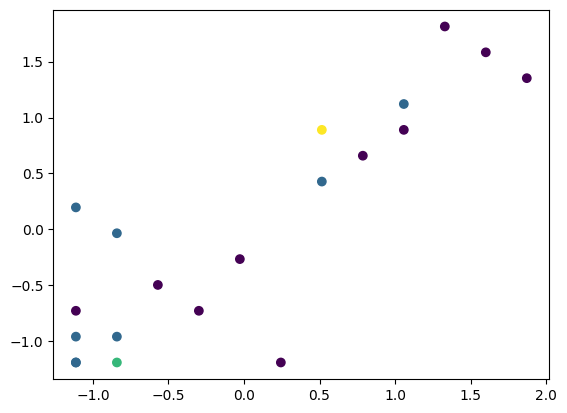

In [202]:
plt.scatter(scale[:,0], scale[:,1], c=labels)
plt.show()